./Data/Images/G0/A1G0COL_210_20X_YZ.tif ./Data/Labels/Labeled G0/A1G0COL_210_20X_YZ.json
./Data/Images/G0/A1G0COL_211_20X_YZ.tif ./Data/Labels/Labeled G0/A1G0COL_211_20X_YZ.json
./Data/Images/G0/A1G0COL_212_20X_YZ.tif ./Data/Labels/Labeled G0/A1G0COL_212_20X_YZ.json
./Data/Images/G0/A1G0COL_213_20X_YZ.tif ./Data/Labels/Labeled G0/A1G0COL_213_20X_YZ.json
./Data/Images/G0/A1G0COL_214_20X_YZ.tif ./Data/Labels/Labeled G0/A1G0COL_214_20X_YZ.json
./Data/Images/G0/A1G0COL_215_20X_YZ.tif ./Data/Labels/Labeled G0/A1G0COL_215_20X_YZ.json
./Data/Images/G0/A1G0COL_216_20X_YZ.tif ./Data/Labels/Labeled G0/A1G0COL_216_20X_YZ.json
./Data/Images/G0/A1G0COL_217_20X_YZ.tif ./Data/Labels/Labeled G0/A1G0COL_217_20X_YZ.json
./Data/Images/G0/A1G0COL_218_20X_YZ.tif ./Data/Labels/Labeled G0/A1G0COL_218_20X_YZ.json
./Data/Images/G0/A1G0COL_21_20X_YZ.tif ./Data/Labels/Labeled G0/A1G0COL_21_20X_YZ.json
./Data/Images/G0/A1G0COL_22_20X_YZ.tif ./Data/Labels/Labeled G0/A1G0COL_22_20X_YZ.json
./Data/Images/G0/A1G0COL_

the actual len of the gt vect is :  7
the actual len of the pred vect is :  7
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  0.0
[0, 0, 0, 0, 0, 0, 0]
[2, 1, 2, 0, 0, 2, 2]
image_id
{'id': 'A1G0COL_211_20X_YZ', 'source': 'dataset', 'path': './Data/Images/G0/A1G0COL_211_20X_YZ.tif', 'mask': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        

the actual len of the gt vect is :  52
the actual len of the pred vect is :  52
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  0.08333333333333333
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
image_id
{'id': 'A1G0COL_216_20X_YZ', 'source': 'dataset', 'path': './Data/Images/G0/A1G0COL_216_20X_YZ.tif', 'mask': array([[[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        ...,
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False]],

       [[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        ...,
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False]],

the actual len of the gt vect is :  83
the actual len of the pred vect is :  83
Average precision of this image :  0.3333333333333333
The actual mean average precision for the whole images (matterport methode)  0.09166666666666667
[2, 0, 0, 0, 0]
[0, 1, 1, 2, 2]
image_id
{'id': 'A1G0COL_22_20X_YZ', 'source': 'dataset', 'path': './Data/Images/G0/A1G0COL_22_20X_YZ.tif', 'mask': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False]

the actual len of the gt vect is :  123
the actual len of the pred vect is :  123
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  0.06547619047619048
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 0, 0, 0, 1, 2, 1, 2, 2, 2, 2]
image_id
{'id': 'A1G0COL_26_20X_YZ', 'source': 'dataset', 'path': './Data/Images/G0/A1G0COL_26_20X_YZ.tif', 'mask': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False

the actual len of the gt vect is :  157
the actual len of the pred vect is :  157
Average precision of this image :  0.1666666716337204
The actual mean average precision for the whole images (matterport methode)  0.06388888922002581
[2, 0, 0, 0, 0, 0, 0, 0]
[2, 2, 0, 0, 0, 0, 2, 2]
image_id
{'id': 'A1G0COL_310_20X_YZ', 'source': 'dataset', 'path': './Data/Images/G0/A1G0COL_310_20X_YZ.tif', 'mask': array([[[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        ...,
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False]],

       [[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        ...,
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False]],

       [[False, False, False,

the actual len of the gt vect is :  185
the actual len of the pred vect is :  185
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  0.05227272754365748
[0, 0, 0, 0]
[1, 2, 2, 1]
image_id
{'id': 'A1G0COL_314_20X_YZ', 'source': 'dataset', 'path': './Data/Images/G0/A1G0COL_314_20X_YZ.tif', 'mask': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
      

c:\users\sedra\venv\lib\site-packages\mask_rcnn-2.1-py3.6.egg\mrcnn\utils.py:741: RuntimeWarning: invalid value encountered in true_divide


the actual len of the gt vect is :  214
the actual len of the pred vect is :  214
Average precision of this image :  nan
The actual mean average precision for the whole images (matterport methode)  nan
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 2, 2, 2, 2, 2, 2, 2, 2]
image_id
{'id': 'A1G0COL_31_20X_YZ', 'source': 'dataset', 'path': './Data/Images/G0/A1G0COL_31_20X_YZ.tif', 'mask': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [Fa

the actual len of the gt vect is :  238
the actual len of the pred vect is :  238
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[0, 0, 0, 0, 0, 0]
[1, 2, 1, 0, 0, 2]
image_id
{'id': 'A1G0COL_35_20X_YZ', 'source': 'dataset', 'path': './Data/Images/G0/A1G0COL_35_20X_YZ.tif', 'mask': array([[[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        ...,
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False]],

       [[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        ...,
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, 

the actual len of the gt vect is :  274
the actual len of the pred vect is :  274
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 0, 0, 1, 2, 2, 2, 2, 1, 2]
image_id
{'id': 'A1G0COL_39_20X_YZ', 'source': 'dataset', 'path': './Data/Images/G0/A1G0COL_39_20X_YZ.tif', 'mask': array([[[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        ...,
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False]],

       [[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        ...,
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False]],

       [[False, False, False, False, False],
     

{'id': 'A1G0COL_412_20X_YZ', 'source': 'dataset', 'path': './Data/Images/G0/A1G0COL_412_20X_YZ.tif', 'mask': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]]), 'class_ids': array([0])}
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 

the actual len of the gt vect is :  343
the actual len of the pred vect is :  343
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[0, 2, 0, 0, 0, 0, 0]
[2, 2, 2, 2, 0, 0, 1]
image_id
{'id': 'A1G0COL_416_20X_YZ', 'source': 'dataset', 'path': './Data/Images/G0/A1G0COL_416_20X_YZ.tif', 'mask': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, Fals

the actual len of the gt vect is :  372
the actual len of the pred vect is :  372
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[0, 0, 0]
[2, 2, 2]
image_id
{'id': 'A1G0COL_43_20X_YZ', 'source': 'dataset', 'path': './Data/Images/G0/A1G0COL_43_20X_YZ.tif', 'mask': array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
       

the actual len of the gt vect is :  400
the actual len of the pred vect is :  400
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[0, 0, 0, 0, 0]
[2, 0, 0, 0, 0]
image_id
{'id': 'A1G0COL_47_20X_YZ', 'source': 'dataset', 'path': './Data/Images/G0/A1G0COL_47_20X_YZ.tif', 'mask': array([[[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        ...,
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False]],

       [[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        ...,
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False]],

       [[False, False, False, False, False],
        [False, False, False, False

the actual len of the gt vect is :  429
the actual len of the pred vect is :  429
Average precision of this image :  0.1666666716337204
The actual mean average precision for the whole images (matterport methode)  nan
[0, 2, 2, 0, 0, 0, 0]
[1, 2, 2, 1, 1, 2, 1]
image_id
{'id': 'A1G0COL_511_20X_YZ', 'source': 'dataset', 'path': './Data/Images/G0/A1G0COL_511_20X_YZ.tif', 'mask': array([[[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        ...,
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False]],

       [[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        ...,
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False

the actual len of the gt vect is :  469
the actual len of the pred vect is :  469
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[0, 0, 0, 0, 0, 0, 0, 0]
[1, 2, 2, 0, 0, 1, 2, 2]
image_id
{'id': 'A1G0COL_515_20X_YZ', 'source': 'dataset', 'path': './Data/Images/G0/A1G0COL_515_20X_YZ.tif', 'mask': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False]

the actual len of the gt vect is :  501
the actual len of the pred vect is :  501
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[2, 2, 0, 0]
[0, 0, 2, 2]
image_id
{'id': 'A1G0COL_52_20X_YZ', 'source': 'dataset', 'path': './Data/Images/G0/A1G0COL_52_20X_YZ.tif', 'mask': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
       

{'id': 'A1G0COL_56_20X_YZ', 'source': 'dataset', 'path': './Data/Images/G0/A1G0COL_56_20X_YZ.tif', 'mask': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]]), 'class_ids': array([0])}
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 10

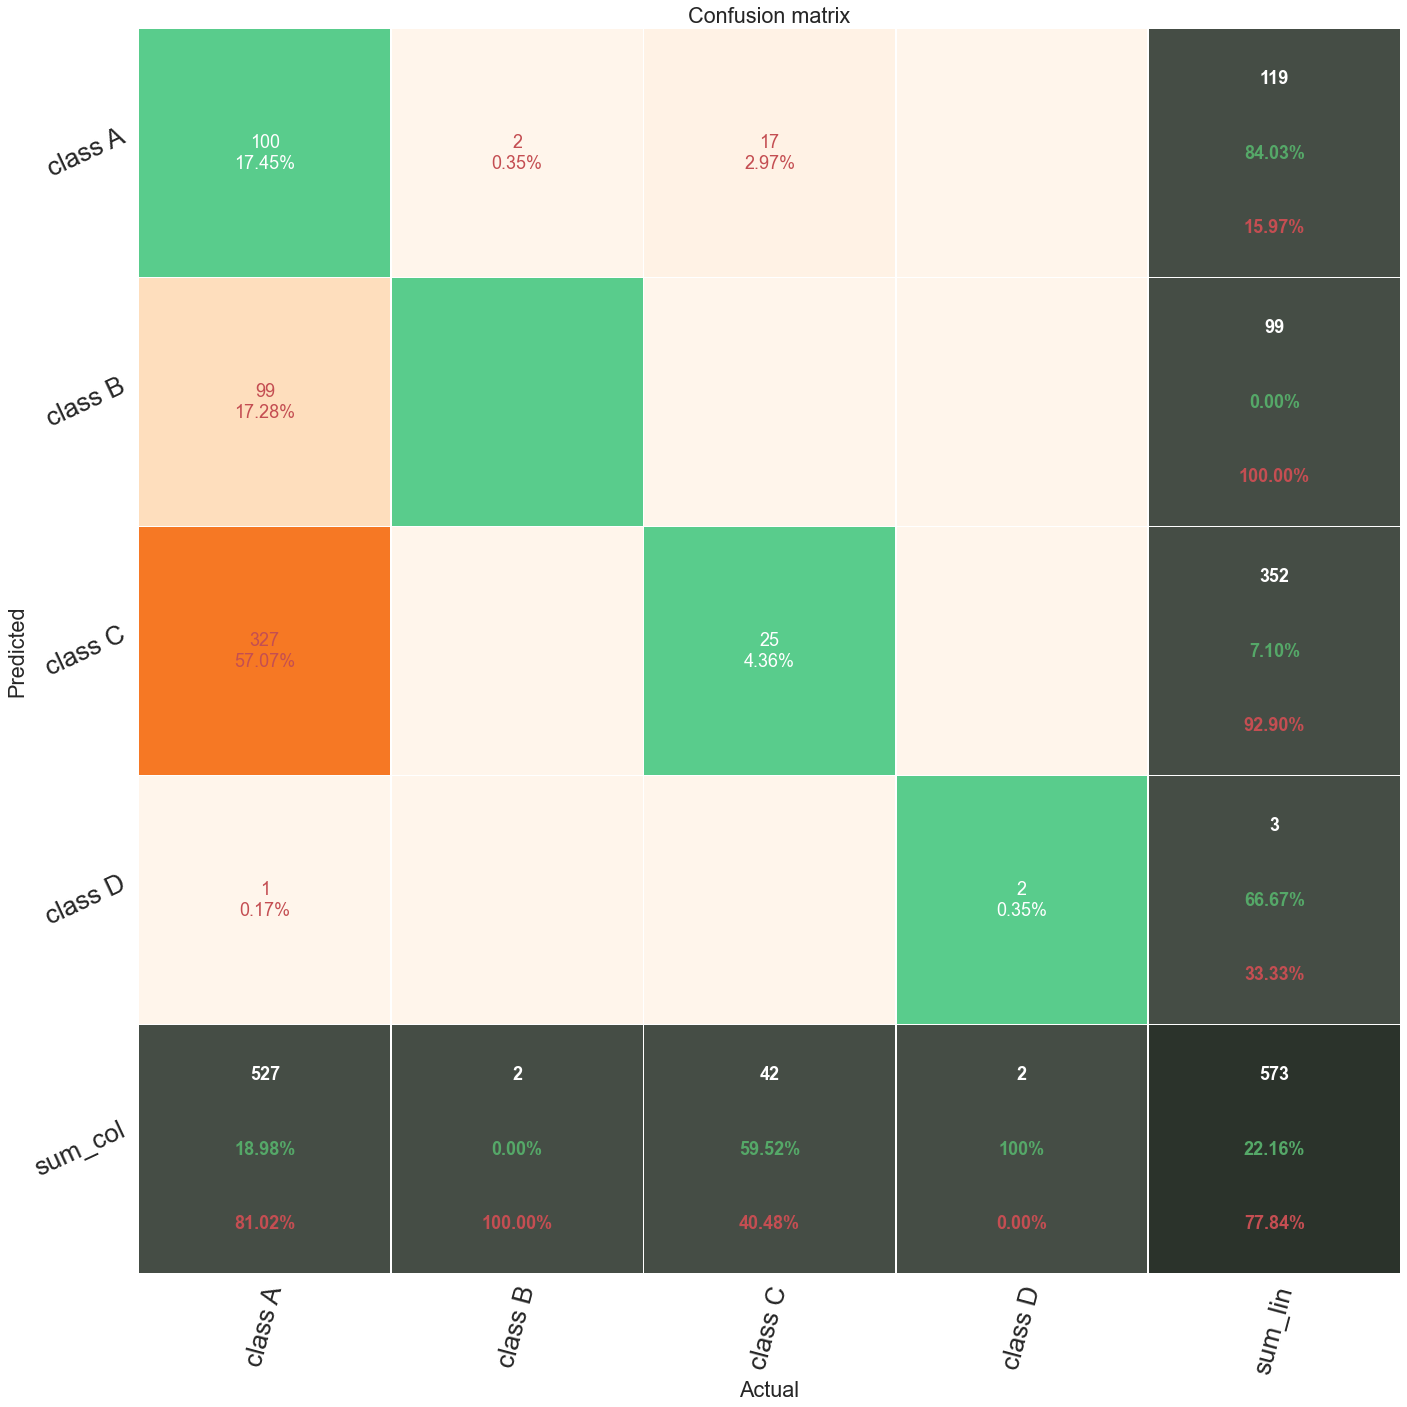

In [12]:
# an example of plotting confusion matrix.
# the first step consists of computing ground-truth and prediction vectors for all images.
# using these vectors, the plot_confusion_matrix_from_data function plots the CM and computes tps fps and fns
from mrcnn import utils
import mrcnn.model
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
import pandas as pd
import numpy as np
import os 
from normalize_classnames import normalize_classname
import json
import cv2

# generate list of validation files
f = open('validation.txt', 'r+')
val_files = ['C:/git/ML-AM-MQP'+line.strip() for line in f.readlines()]
f.close()

#ground-truth and predictions lists
gt_tot = np.array([])
pred_tot = np.array([])
#mAP list
mAP_ = []

CLASSES = ['lack of fusion porosity', 'keyhole porosity', 'other']

class InferenceConfig(Config):
    NAME = 'inference'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 3 + 1
     
class InferenceDataset(utils.Dataset):

  num_classes = 4
    
  # define constants
  BASE_IMAGES_DIR = './Data/Images/' # directory where all images can be found
  BASE_ANNOTATIONS_DIR = './Data/Labels/' # directory where all images labels can be found
  IMAGES_DIRS = ['G0/'] # list of directories where images are contained
  ANNOTATIONS_DIRS = ['Labeled G0/'] # corresponding list of directories where annotations are contained

  # BASE_IMAGES_DIR = './Data/Trial/'
  # BASE_ANNOTATIONS_DIR = './Data/Trial/'
  # IMAGES_DIRS = ['H6/']
  # ANNOTATIONS_DIRS = ['Labeled H6/']

  TRAIN_TEST_SPLIT = .8 # proportion of images to use for training set, remainder will be reserved for validation
  CLASSES = ['lack of fusion porosity', 'keyhole porosity', 'other'] # all annotation classes

  '''
  Loads the dataset
  validation: Indicates whether the current set is the validation set
  '''
  def load_dataset(self, validation=False):
    image_paths = []
    annotation_paths = []
    image_ids = []

    for i in range(len(self.IMAGES_DIRS)):
      image_paths.append([])
      annotation_paths.append([])
      image_ids.append([])
      i_dir = self.BASE_IMAGES_DIR + self.IMAGES_DIRS[i]
      a_dir = self.BASE_ANNOTATIONS_DIR + self.ANNOTATIONS_DIRS[i]
      for file in os.listdir(i_dir):
        i_id = file[:-4]
        image_ids[i].append(i_id)
        image_paths[i].append(i_dir+i_id+'.tif')
        annotation_paths[i].append(a_dir+i_id+'.json')

    if (len(image_paths) != len(annotation_paths)): # raise exception if mismatch betwaeen number of images and annotations
      raise(ValueError('Number of images and annotations must be equal'))

    # total_images = len(image_paths) # count of all images to be processed
    # total_images_path = int(total_images / len(self.IMAGES_DIRS)) # count of images per subdirectory
    # val_images = (int) (total_images * (1-self.TRAIN_TEST_SPLIT)) # the total number of images in the validation set
    # val_images_path = int(val_images / len(self.IMAGES_DIRS)) # number of validation images per subdirectory

    # configure dataset
    for i in range(len(self.CLASSES)):
      self.add_class('dataset', i+1, self.CLASSES[i]) # add classes to model

    # add images and annotations to dataset, ensuring an even distribution
    for i in range(len(image_paths)):
      images = len(image_paths[i])
      train_images = int(images * self.TRAIN_TEST_SPLIT)
      val_images = int(images * (1 - self.TRAIN_TEST_SPLIT))
      if validation:
        for j in range(val_images):
          image_id = image_ids[i][j]
          image_path = image_paths[i][j]
          annotation_path = annotation_paths[i][j]

          mask, class_ids = self.extract_mask(image_path, annotation_path)

          if len(mask) != 0: # skip images with no annotations
              self.add_image('dataset',
                             image_id=image_id,
                             path=image_path,
                             mask=mask,
                             class_ids=class_ids)

      else:
        for j in range(train_images):
          image_id = image_ids[i][j + val_images]
          image_path = image_paths[i][j + val_images]
          annotation_path = annotation_paths[i][j + val_images]

          mask, class_ids = self.extract_mask(image_path, annotation_path)

          if len(mask) != 0:
              self.add_image('dataset',
                             image_id=image_id,
                             path=image_path,
                             mask=mask,
                             class_ids=class_ids)

  '''
  Extracts a mask from an image
  image_id: The image id to extract the mask from
  Returns a mask and a corresponding list of class ids
  '''
  def load_mask(self, image_id):

    info = self.image_info[image_id] # extract image info from data added earlier
    mask = info['mask']
    class_ids = info['class_ids']

    return mask, class_ids

  '''
  Extracts the mask data from an image and its respective annotation
  image_path: Path to the image
  annotation_path: Path to the annotation
  Returns a mask and a list of class ids
  '''
  def extract_mask(self, image_path, annotation_path):
    if not os.path.exists(annotation_path): # if the annotation path is not found, it is named differently than its source image
        annotation_path = annotation_path[:-5] + '_20X_YZ.json'

    print(image_path, annotation_path)

    f_ann = open(annotation_path,)
    annotation_json = json.load(f_ann)

    if not annotation_json['shapes']: # if there are no annotations to be extracted
        return [], [] # empty list return values will be ignored and thus image is ignored

    class_ids = []
    image = cv2.imread(image_path)
    height = image.shape[0]
    width = image.shape[1]

    annotation_list = []
    [annotation_list.append(shape) for shape in annotation_json['shapes'] if shape['shape_type'] =='rectangle'
     and normalize_classname(shape['label']) != 'gas entrapment porosity'] # get annotations in a list
    mask = np.zeros([height, width, len(annotation_list)], dtype='uint8') # initialize array of masks for each bounding box

    for i in range(len(annotation_list)):
      a = annotation_list[i]

      # extract row and col data and crop image to annotation size
      col_min, col_max = int(min(a['points'][0][0], a['points'][1][0])), int(max(a['points'][0][0], a['points'][1][0]))
      row_min, row_max = int(min(a['points'][0][1], a['points'][1][1])), int(max(a['points'][0][1], a['points'][1][1]))
      col_min, col_max, row_min, row_max = self.normalize_dimensions(col_min, col_max, row_min, row_max)
      cropped_img = image[row_min:row_max, col_min:col_max]  # crop image to size of bounding box
      cropped_img_gray = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
      edged = cv2.Canny(cropped_img_gray, 30, 200)

      # apply contour to image and fill
      kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
      dilated = cv2.dilate(edged, kernel)
      contours, hierarchy = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      polygon = np.zeros(cropped_img.shape)
      color = [255, 255, 255]
      cv2.fillPoly(polygon, contours, color)

      # normalize polygon to all boolean values and insert into mask
      polygon_bool = np.alltrue(polygon == color, axis=2)
      mask[row_min:row_max, col_min:col_max, i] = polygon_bool

      # draw contour and mask
      # cv2.drawContours(edged, contours, -1, (0, 255, 0), 1)
      # imS = cv2.resize(edged, (512, 512))
      # cv2.imshow('Contours', imS)
      # cv2.waitKey(0)
      # cv2.imshow('Polygon', cv2.resize(polygon, (512, 512)))
      # cv2.waitKey(0)

      # extract class id and append to list
      class_label = normalize_classname(a['label'])
      class_id = self.CLASSES.index(class_label)
      class_ids.append(class_id)

    return mask.astype(np.bool), np.array(class_ids, dtype=np.int32)

  '''
  Ensures extracted row and column coords are not out of bounds
  '''
  def normalize_dimensions(self, col_min, col_max, row_min, row_max):
      return max(col_min, 0), col_max, max(row_min, 0), row_max
    
    
    
    
       
config = InferenceConfig()
dataset = InferenceDataset()
dataset.load_dataset()
dataset.prepare()

model = MaskRCNN(mode='inference',
                 config=InferenceConfig(), model_dir='./')
model.load_weights(filepath='custom_mrcnn.h5', by_name=True)

#compute gt_tot, pred_tot and mAP for each image in the test dataset
for image_id in dataset.image_ids:
    
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        mrcnn.model.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    info = dataset.image_info[image_id]

    # Run the model
    results = model.detect([image], verbose=1)
    r = results[0]
    
    #compute gt_tot and pred_tot
    gt, pred = utils.gt_pred_lists(gt_class_id, gt_bbox, r['class_ids'], r['rois'])
    gt_tot = np.append(gt_tot, gt)
    pred_tot = np.append(pred_tot, pred)
    
    #precision_, recall_, AP_ 
    AP_, precision_, recall_, overlap_ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
    #check if the vectors len are equal
    print("the actual len of the gt vect is : ", len(gt_tot))
    print("the actual len of the pred vect is : ", len(pred_tot))
    
    mAP_.append(AP_)
    print("Average precision of this image : ",AP_)
    print("The actual mean average precision for the whole images (matterport methode) ", sum(mAP_)/len(mAP_))
    print(gt)
    print(pred)
#     print("Ground truth object : "+dataset.class_names[gt])
#     print("Predicted object : "+dataset.class_names[pred])
 

gt_tot=gt_tot.astype(int)
pred_tot=pred_tot.astype(int)
#save the vectors of gt and pred
save_dir = "output"
gt_pred_tot_json = {"gt_tot" : gt_tot, "pred_tot" : pred_tot}
df = pd.DataFrame(gt_pred_tot_json)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
df.to_json(os.path.join(save_dir,"gt_pred_test.json"))
    
#print the confusion matrix and compute true postives, false positives and false negative for each class: 
#ps : you can controle the figure size and text format by choosing the right values
#tp, fp, fn = utils.plot_confusion_matrix_from_data(gt_tot, pred_tot, dataset.class_names, fz=18, figsize=(20,20), lw=0.5)

###########################################################################################################################

#since in this notebook i didnt run the loop above, here is an example of plotting using manual generated vectors :
#let 0 be the background class
#gt_tot=[1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,0,1,2,3,0,1,2,3,0,1,2,0]
#pred_tot=[1,2,3,3,2,1,1,2,3,1,2,3,1,2,0,2,2,2,3,1,0,0,3,2,1,2,0]

#supose we have 1 image containing the gt classes bellow :
gt_class_id = np.array([1,2,3,1,2,3])
#with the bbox :
gt_bbox = np.array([np.array([10,100,20,200]),np.array([100,10,200,20]),np.array([110,15,220,25]),np.array([20,200,20,200]),
                    np.array([90,15,220,20]),np.array([100,10,150,20])])
#and the model detected the classes : 
pred_class_id = np.array([2,3,2,3,2,3])
#with the bbox : 
pred_bbox = np.array([np.array([100,10,200,20]),np.array([110,15,220,25]),np.array([90,15,220,20]),np.array([101,20,100,21]),
                    np.array([500,20,1,20]),np.array([100,10,150,20])])

#for this image, the gt and pred lists are :    
gt, pred = utils.gt_pred_lists(gt_class_id, gt_bbox, pred_class_id, pred_bbox)
gt_tot = np.append(gt_tot, gt)
pred_tot = np.append(pred_tot, pred)

print("ground truth list : ",gt_tot)
print("predicted list : ",pred_tot)

#here i didnt set the columns list, since in the code if columns is note specified 
#it generates automatically a list from "class A" to "class ..". in this example, class A should be the background
#Note : class A is the backround in this example
tp,fp,fn=utils.plot_confusion_matrix_from_data(gt_tot,pred_tot,fz=18, figsize=(20,20), lw=0.5)

In [ ]:
print("tp for each class :",tp)
print("fp for each class :",fp)
print("fn for each class :",fn)

#eliminate the background class (class A) from tps fns and fns lists since it doesn't concern us anymore : 
del tp[0]
del fp[0]
del fn[0]
print("\n########################\n")
print("tp for each class :",tp)
print("fp for each class :",fp)
print("fn for each class :",fn)